[View in Colaboratory](https://colab.research.google.com/github/joheras/CLoDSA/blob/master/notebooks/CLODSA_Instance_Segmentation.ipynb)

# Augmenting a dataset for detection using COCO format

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to detection that was annotated using the [COCO format](http://cocodataset.org/#home). 

We will use a small dataset of shapes. 

In [1]:
!wget https://www.dropbox.com/s/eus5u6ug1s7ftzc/shapes.zip?dl=0 -O shapes.zip
!unzip shapes.zip

--2020-03-17 08:26:10--  https://www.dropbox.com/s/eus5u6ug1s7ftzc/shapes.zip?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.1, 2620:100:6024:1::a27d:4401
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/eus5u6ug1s7ftzc/shapes.zip [siguiente]
--2020-03-17 08:26:10--  https://www.dropbox.com/s/raw/eus5u6ug1s7ftzc/shapes.zip
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uceea6692b77902753e7fec793ab.dl.dropboxusercontent.com/cd/0/inline/A0EGnqxdewAWA3RsgyKchuvuss379nwlKNYysOmKlc2E9gjJ2LaBv6LDH9nJ_wi4zhfBZmgL6vTu8C9oXYcR2mh0lQ8KcZgpBONUaQa4cvGopWC0AIEy9X24lP131ti2nSw/file# [siguiente]
--2020-03-17 08:26:11--  https://uceea6692b77902753e7fec793ab.dl.dropboxusercontent.com/cd/0/inline/A0EGnqxdewAWA3RsgyKchuvuss379nwlKNYysOmKlc2E9gjJ2LaBv6LDH9nJ_wi4zhfBZmgL6vTu8C9oXYcR2mh0lQ8KcZgpB

We can check the elements of the shapes folder that are a json file with the coco annotation and two images.

In [2]:
!ls shapes/

1000.jpeg  1001.jpeg  annotations.json


We create the output folder.

In [2]:
!mkdir output

## Augmentation techniques

For this example, we consider three augmentation techniques. 

The augmentation techniques applied in this example are:
- Rotation.
- Flip.

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [ ]:
!pip install clodsa

## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA.

In [3]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import cv2
%matplotlib inline

/home/jonathan/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, even if we are working on a detection problem, we must indicate that is an instance segmentation problem since the COCO format includes this kind of information.

In [4]:
PROBLEM = "instance_segmentation"

_The annotation mode_. The annotation is provided using the coco format in a file called annotations.json. 

In [5]:
ANNOTATION_MODE = "coco"

_The input path_. The input path containing the images. 

In [6]:
INPUT_PATH = "shapes"

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [7]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called output.  

In [8]:
OUTPUT_MODE = "coco"
OUTPUT_PATH= "output/"

Using the above information, we can create our augmentor object. 

In [9]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



First of all, we must define a transformer generator.

In [10]:
transformer = transformerGenerator(PROBLEM)

_Rotations:_

In [11]:
for angle in [90,180]:
    rotate = createTechnique("rotate", {"angle" : angle})
    augmentor.addTransformer(transformer(rotate))

_Flips:_

In [12]:
flip = createTechnique("flip",{"flip":1})
augmentor.addTransformer(transformer(flip))

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [13]:
augmentor.applyAugmentation()

We can now check the elements of the output folder. 

In [16]:
!ls output/

0_1000.jpeg  1_1000.jpeg  2_1000.jpeg  annotation.json
0_1001.jpeg  1_1001.jpeg  2_1001.jpeg


Finally, we can visualize the results using the following functions.

In [35]:
import json

def getImageId(name,data):
    images = data['images']
    for image_data in images:
        if image_data['file_name']==name:
            return image_data['id']


        
def showBoxes(image_path,annotation_file):
    image = cv2.imread(image_path)
    with open(annotation_file) as f:
        data = json.load(f)
    image_id = getImageId(image_path[image_path.rfind('/')+1:],data)
    boxes = []
    for annot in data['annotations']:
        if annot['image_id']==image_id:
            boxes.append((annot['category_id'],annot['bbox']))
    categoriesData = data['categories']
    categories =  {cat['id']:cat['name'] for cat in categoriesData}
    cloneImg = image.copy()
    for box in boxes:
        (_,(x,y,w,h)) = box
        cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(255,0,0),1)
    plt.imshow(cloneImg[:,:,::-1])

Original images.

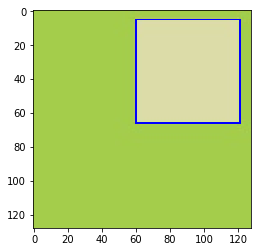

In [38]:
showBoxes('shapes/1000.jpeg','shapes/annotations.json')

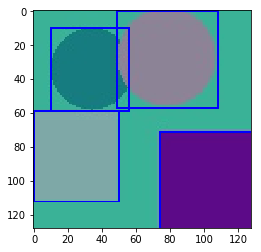

In [39]:
showBoxes('shapes/1001.jpeg','shapes/annotations.json')

Generated images.

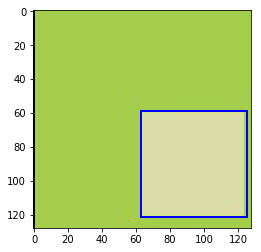

In [41]:
showBoxes('output/0_1000.jpeg','output/annotation.json')

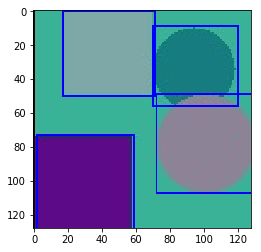

In [42]:
showBoxes('output/0_1001.jpeg','output/annotation.json')

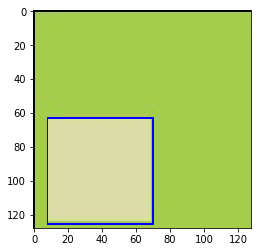

In [43]:
showBoxes('output/1_1000.jpeg','output/annotation.json')

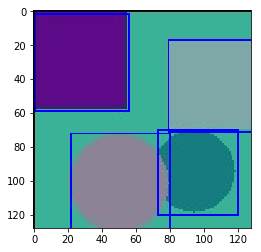

In [44]:
showBoxes('output/1_1001.jpeg','output/annotation.json')

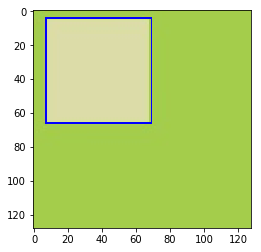

In [45]:
showBoxes('output/2_1000.jpeg','output/annotation.json')

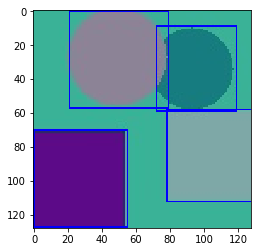

In [46]:
showBoxes('output/2_1001.jpeg','output/annotation.json')